## 该代码在kaggle中使用P100成功运行
### 链接：https://www.kaggle.com/code/czy111/clip-guided-vqvae-and-vqgan

## VQVAE模型构建

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

##下采样卷积层
class DownSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,4,2,1)
        self.relu=nn.ReLU()
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x):
        x=self.relu(x)
        return self.main(x)
    
##上采样卷积层
class UpSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,5,1,2)
        self.relu=nn.ReLU()
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x):
        _,_,H,W=x.shape
        x=self.relu(x)
        x=F.interpolate(
            x,scale_factor=2,mode='nearest'
        )
        return self.main(x)

class AttnBlock(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.group_norm=nn.GroupNorm(32,in_c)
        self.proj_q=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_k=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_v=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_out=nn.Conv2d(in_c,in_c,1,1,0)
        self.initialize()
    def initialize(self):
        for layer in [self.proj_q,self.proj_k,self.proj_v,self.proj_out]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.proj_out.weight,gain=1e-5)
    def forward(self,x):
        B,C,H,W=x.shape
        h=self.group_norm(x)
        q=self.proj_q(x)
        k=self.proj_k(x)
        v=self.proj_v(x)
        q=q.permute(0,2,3,1).view(B,H*W,C)
        k=k.view(B,C,H*W)
        w=torch.bmm(q,k)*(int(C)**(-0.5))
        w=F.softmax(w,dim=-1)##(B,H*W,H*W)
        v=v.permute(0,2,3,1).view(B,H*W,C)
        h=torch.bmm(w,v)
        h=h.view(B,H,W,C).permute(0,3,1,2)
        h=self.proj_out(h)
        return x+h
##残差块
class ResBlock(nn.Module):
    def __init__(self,in_c,out_c,dropout,attn=False):
        super().__init__()
        ## block1:调整通道数
        self.block1=nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_c,out_c,3,1,1),
            
        )
        self.block2=nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_c,out_c,1,1,0), 
        )
        
        if in_c!=out_c:
            self.short_cut=nn.Conv2d(in_c,out_c,1,1,0)
        else:
            self.short_cut=nn.Identity()
            
        if attn:
            self.attn=AttnBlock(out_c)
        else:
            self.attn=nn.Identity()
        self.initialize()
    def initialize(self):
        for module in self.modules():
            if isinstance(module,(nn.Conv2d,nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
        #nn.init.xavier_uniform_(self.block2[-1].weight,gain=1e-5)
    def forward(self,x):
        h=self.block1(x)
        h=self.block2(h)
        h=h+self.short_cut(x)
        return h

##输入图片通道数
input_dim=3

#编码器
class Encoder(nn.Module):
    """
    c:隐藏层通道数
    layer_num:下采样块数，设置为2较好，否则重建图片失真比较严重
    num_res_block:残差块数量
    """
    def __init__(self,c=128,layer_num=2,num_res_block=2,dropout=0.1,attn=False):
        super().__init__()
        self.head=nn.Sequential(nn.Conv2d(input_dim,c,5,1,2))##增加通道数
        self.down_blocks=nn.ModuleList()
        now_c=c
        for _ in range(layer_num):
            self.down_blocks.append(DownSample(now_c))
        self.down_blocks.append(nn.Conv2d(now_c,now_c,3,1,1))
        for i in range(num_res_block):
            self.down_blocks.append(
                    ResBlock(now_c,now_c,dropout,attn=((i==1) and attn))
                )

        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.head[0].weight)
        nn.init.zeros_(self.head[0].bias)
    def forward(self,x):
        h=self.head(x)
        for layer in self.down_blocks:
            h=layer(h)
        return h

## 解码器
class Decoder(nn.Module):
    """
    c:隐藏层通道数
    layer_num:上采样块数，应该和Encoder保持一致
    num_res_block:残差块数量
    """
    def __init__(self,c=128,layer_num=2,num_res_block=2,dropout=0.1,attn=False):
        super().__init__()
        self.up_blocks=nn.ModuleList()
        now_c=c
        #self.up_blocks.append(nn.Conv2d(now_c,now_c,3,1,1))
        for i in range(num_res_block):
            self.up_blocks.append(
                    ResBlock(now_c,now_c,dropout,attn=((i==1) and attn))
                )
        self.up_blocks.append(nn.Conv2d(now_c,now_c,3,1,1))
        for _ in range(layer_num):
            self.up_blocks.append(UpSample(now_c))
           
        self.tail=nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(now_c,input_dim,3,1,1),
        )## 更改输出通道数
        
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.tail[-1].weight)
        nn.init.zeros_(self.tail[-1].bias)
    def forward(self,x):
        h=x
        for layer in self.up_blocks:
            h=layer(h)
        h=self.tail(h)
        return h
    


## VQ层，主要用于学习codebook
class VectorQuantizer(nn.Module):
    def __init__(self, device,num_embeddings, embedding_dim, beta, gamma, decay=0, epsilon=1e-5):
        super().__init__()
        self.e_dim=embedding_dim
        self.n_e=num_embeddings
        self.beta=beta
        self.gamma=gamma
        
        self.embedding=nn.Embedding(num_embeddings,embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / num_embeddings,
                                               1.0 / num_embeddings)
        
        self._ema_cluster_size=torch.zeros(num_embeddings).to(device)
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, embedding_dim))
        self._ema_w.data.normal_()
        self._decay=decay
        self._epsilon=epsilon
    def forward(self,inputs):
        ## B,C,W,H->B,W,H,C
        inputs=inputs.permute(0,2,3,1).contiguous()
        input_shape=inputs.shape
        ## B*W*H,C
        flat_inputs=inputs.view(-1,input_shape[-1])
        ## 计算距离
        ## flat_inputs(B*W*H,d)
        ## embedding(K,d)
        dists=(torch.sum(flat_inputs**2,dim=1,keepdim=True)+
               torch.sum(self.embedding.weight**2,dim=1)-
               2*torch.matmul(flat_inputs,self.embedding.weight.t())
              )
        
        encoding_indices=torch.argmin(dists,dim=1).unsqueeze(1)
        encoding=torch.zeros(encoding_indices.shape[0],self.n_e,device=inputs.device)
        encoding.scatter_(1, encoding_indices, 1)
        ## (B*W*H,K)
        quantized=torch.matmul(encoding.detach(),self.embedding.weight).view(input_shape)
        
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encoding, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self.n_e * self._epsilon) * n) 
            
            dw = torch.matmul(encoding.t(), flat_inputs)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw) 
            
            self.embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1)) # 论文中公式(8)
    
        loss1=F.mse_loss(quantized.detach(),inputs)
        loss2=F.mse_loss(quantized,inputs.detach())
        ## 让z去逼近z_q似乎更好一些，有利于减小codebook weight的方差
        Discrete_loss=self.beta*loss1+self.gamma*loss2
        
        quantized=inputs+(quantized-inputs).detach()
        ## 计算每个向量被使用次数
        avg_probs=torch.mean(encoding,dim=0)
        ## 计算交叉熵
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return Discrete_loss,quantized.permute(0, 3, 1, 2).contiguous(),encoding_indices,perplexity
        

## VQVAE完整模型
class VQVAE(nn.Module):
    def __init__(self,device,hidden_dim,num_embeddings, embedding_dim,  beta, gamma,dropout=0.1,decay=0):
        super().__init__()
        layer_num=2
        self.layer_num=layer_num
        attn=(num_embeddings==16384)
        self.encoder=Encoder(c=hidden_dim,layer_num=layer_num,num_res_block=2,dropout=dropout,attn=attn)
        self.decoder = Decoder(c=hidden_dim,layer_num=layer_num,num_res_block=2,dropout=dropout,attn=attn)
        self.pre_vq_conv = nn.Sequential(nn.Conv2d(hidden_dim, embedding_dim,1, 1,0))
        self.aft_vq_conv = nn.Sequential(nn.Conv2d(embedding_dim,hidden_dim,1, 1,0))
        self.quantize = VectorQuantizer(device,num_embeddings, embedding_dim,
                                       beta,gamma,decay)
        
    def forward(self,x):
        z=self.encoder(x)
        z=self.pre_vq_conv(z)
        loss,quantized,avgprobs,perplexity=self.quantize(z)
        #print(quantized.shape)
        quantized=self.aft_vq_conv(quantized)
        x_recon=self.decoder(quantized)
        return loss,x_recon,perplexity

    ## 从z_q得到重建图像
    def decode(self,quantized):
        quantized=self.aft_vq_conv(quantized)
        x_recon=self.decoder(quantized)
        return x_recon   
    
    ## 从输入图像得到z_q
    def encode(self,x):
        z=self.encoder(x)
        z=self.pre_vq_conv(z)
        loss,quantized,avgprobs,perplexity=self.quantize(z)
        #z=self.aft_vq_conv(quantized)
        
        return quantized,None
        

## VQGAN相关依赖配置

In [2]:
import shutil
shutil.rmtree('/opt/conda/lib/python3.10/site-packages/aiohttp-3.9.1.dist-info/')

In [ ]:
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers

In [ ]:
## 下载官方检查点
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

## CLIP相关依赖配置

In [ ]:
!pip install ftfy regex tqdm omegaconf pytorch-lightning einops transformers
## 中文clip
!pip install cn_clip
## 英文clip
!git clone https://github.com/openai/CLIP

## 由于版本问题需要修改VQGAN的utils.py文件

In [81]:
%%writefile /kaggle/working/taming-transformers/taming/data/utils.py
import collections
import os
import tarfile
import urllib
import zipfile
from pathlib import Path

import numpy as np
import torch
from taming.data.helper_types import Annotation

int_classes = int
string_classes = str

from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format
from tqdm import tqdm


def unpack(path):
    if path.endswith("tar.gz"):
        with tarfile.open(path, "r:gz") as tar:
            tar.extractall(path=os.path.split(path)[0])
    elif path.endswith("tar"):
        with tarfile.open(path, "r:") as tar:
            tar.extractall(path=os.path.split(path)[0])
    elif path.endswith("zip"):
        with zipfile.ZipFile(path, "r") as f:
            f.extractall(path=os.path.split(path)[0])
    else:
        raise NotImplementedError(
            "Unknown file extension: {}".format(os.path.splitext(path)[1])
        )


def reporthook(bar):
    """tqdm progress bar for downloads."""

    def hook(b=1, bsize=1, tsize=None):
        if tsize is not None:
            bar.total = tsize
        bar.update(b * bsize - bar.n)

    return hook


def get_root(name):
    base = "data/"
    root = os.path.join(base, name)
    os.makedirs(root, exist_ok=True)
    return root


def is_prepared(root):
    return Path(root).joinpath(".ready").exists()


def mark_prepared(root):
    Path(root).joinpath(".ready").touch()


def prompt_download(file_, source, target_dir, content_dir=None):
    targetpath = os.path.join(target_dir, file_)
    while not os.path.exists(targetpath):
        if content_dir is not None and os.path.exists(
            os.path.join(target_dir, content_dir)
        ):
            break
        print(
            "Please download '{}' from '{}' to '{}'.".format(file_, source, targetpath)
        )
        if content_dir is not None:
            print(
                "Or place its content into '{}'.".format(
                    os.path.join(target_dir, content_dir)
                )
            )
        input("Press Enter when done...")
    return targetpath


def download_url(file_, url, target_dir):
    targetpath = os.path.join(target_dir, file_)
    os.makedirs(target_dir, exist_ok=True)
    with tqdm(
        unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=file_
    ) as bar:
        urllib.request.urlretrieve(url, targetpath, reporthook=reporthook(bar))
    return targetpath


def download_urls(urls, target_dir):
    paths = dict()
    for fname, url in urls.items():
        outpath = download_url(fname, url, target_dir)
        paths[fname] = outpath
    return paths


def quadratic_crop(x, bbox, alpha=1.0):
    """bbox is xmin, ymin, xmax, ymax"""
    im_h, im_w = x.shape[:2]
    bbox = np.array(bbox, dtype=np.float32)
    bbox = np.clip(bbox, 0, max(im_h, im_w))
    center = 0.5 * (bbox[0] + bbox[2]), 0.5 * (bbox[1] + bbox[3])
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    l = int(alpha * max(w, h))
    l = max(l, 2)

    required_padding = -1 * min(
        center[0] - l, center[1] - l, im_w - (center[0] + l), im_h - (center[1] + l)
    )
    required_padding = int(np.ceil(required_padding))
    if required_padding > 0:
        padding = [
            [required_padding, required_padding],
            [required_padding, required_padding],
        ]
        padding += [[0, 0]] * (len(x.shape) - 2)
        x = np.pad(x, padding, "reflect")
        center = center[0] + required_padding, center[1] + required_padding
    xmin = int(center[0] - l / 2)
    ymin = int(center[1] - l / 2)
    return np.array(x[ymin : ymin + l, xmin : xmin + l, ...])


def custom_collate(batch):
    r"""source: pytorch 1.9.0, only one modification to original code """

    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return custom_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, collections.abc.Mapping):
        return {key: custom_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(custom_collate(samples) for samples in zip(*batch)))
    if isinstance(elem, collections.abc.Sequence) and isinstance(elem[0], Annotation):  # added
        return batch  # added
    elif isinstance(elem, collections.abc.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [custom_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))


Overwriting /kaggle/working/taming-transformers/taming/data/utils.py


In [11]:
## import相关包
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms,models
import torchvision
from torchvision.transforms import functional as TF

import numpy as np
from IPython import display
from tqdm.notebook import tqdm
import kornia.augmentation as K
from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cn_clip.clip
from cn_clip.clip import load_from_name, available_models
from CLIP import clip

## 梯度替换
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply

## 把输入裁剪到0-1之间
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

clamp_with_grad = ClampWithGrad.apply

In [5]:
## 随机噪声初始化
def random_noise_image(w,h):
    random_image = Image.fromarray(np.random.randint(0,255,(w,h,3),dtype=np.dtype('uint8')))
    return random_image


# 梯度初始化
def gradient_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T


def gradient_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=float)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = gradient_2d(start, stop, width, height, is_horizontal)

    return result

    
def random_gradient_image(w,h):
    array = gradient_3d(w, h, (0, 0, np.random.randint(0,255)), (np.random.randint(1,255), np.random.randint(2,255), np.random.randint(3,128)), (True, False, False))
    random_image = Image.fromarray(np.uint8(array))
    return random_image

## 多个高斯分布叠加初始化
def noise_gen(h,w):
    n=1
    c=3
    noise = torch.zeros([n, c, 1, 1])
    for i in reversed(range(5)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += torch.randn([n, c, h_cur, w_cur]) / 5
    return noise

## 初始化z
def init_z(model,sideX ,sideY):
    if args.init_image:
        if 'http' in args.init_image:
            img = Image.open(urlopen(args.init_image))
        else:
            img = Image.open(args.init_image)
        pil_image = img.convert('RGB')
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        global orgin_x
        pil_tensor = TF.to_tensor(pil_image)
        orgin_x=pil_tensor.detach().to(device)
        pil_tensor=pil_tensor.to(device).unsqueeze(0) * 2 - 1
        z, *_ = model.encode(pil_tensor)
    elif args.init_noise == 'pixels':
        img = random_noise_image(args.size[0], args.size[1])    
        pil_image = img.convert('RGB')
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        pil_tensor = TF.to_tensor(pil_image)
        z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
    elif args.init_noise == 'gradient':
        img = random_gradient_image(args.size[0], args.size[1])
        pil_image = img.convert('RGB')
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        pil_tensor = TF.to_tensor(pil_image)
        z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
    elif args.init_noise=='guass':
        img=noise_gen(args.size[0],args.size[1])
        pil_image=img = TF.to_pil_image(img.div(5).add(0.5).clamp(0, 1)[0])
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        pil_tensor = TF.to_tensor(pil_image)
        z,*_=model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
    else:
        z=None
    return z

## 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

## 重采样
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


## 数据增强
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))
        ## 图像增强管道：随机翻转，随机仿射变换，随机透视变换，随机颜色变换
        self.augs=nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'), # padding_mode=2
            K.RandomPerspective(0.2,p=0.4, ),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),
    )

    def set_cut_pow(self, cut_pow):
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        cutouts = torch.cat(cutouts, dim=0)

        if args.use_augs:
            cutouts = self.augs(cutouts)

        if args.noise_fac:
            facs = cutouts.new_empty([cutouts.shape[0], 1, 1, 1]).uniform_(0, args.noise_fac)
            cutouts = cutouts + facs * torch.randn_like(cutouts)
    
        return clamp_with_grad(cutouts, 0, 1)

## 防止OOM
def clear_cuda_cache(): 
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()

In [6]:
## 提示词处理
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
    
    ## 计算嵌入距离损失
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize((self.embed).unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


## 显示图像
def imshow(img):
    if len(img.size())==4:
        img=img[0]
    TF.to_pil_image(img.cpu()).save('progress.png')   
    display.display(display.Image('progress.png')) 

## 保存结果
def save_result(img,t):
    if not os.path.exists('images'):
        os.mkdir('images')
    if len(img.size())==4:
        img=img[0]
    save_path=f'images/{args.model_type}_{args.prompts[0]}_{str(t)}.png'
    TF.to_pil_image(img.cpu()).save(save_path)
    display.display(display.Image(save_path))

## 获取vqvae参数及模型链接
def get_vqvae_config():
    if '16384' in args.model_type:
        config_path='/kaggle/input/vqvae-16384/vqvae_16384.yaml'
        checkpoint_path='/kaggle/input/vqvae-16384/vqvae_16384.pkl'
    else:
        config_path='/kaggle/input/vqvae-2048/vqvae_2048.yaml'
        checkpoint_path='/kaggle/input/vqvae-2048/vqvae_2048.pkl'
    return config_path,checkpoint_path

## 加载vqvae或vqgan模型 
## vqgan有多个检查点，在实验中我们只使用了imagenet-16384
def load_model():
    from omegaconf import OmegaConf
    if 'vqvae' in args.model_type:
        args.vqvae_config,args.vqvae_checkpoint=get_vqvae_config()
        config = OmegaConf.load(args.vqvae_config)
        model=VQVAE(**config).to(device)
        model.load_state_dict(torch.load(args.vqvae_checkpoint))
    else:
        config = OmegaConf.load(args.vqgan_config)
        if config.model.target == 'taming.models.vqgan.VQModel':
            model = vqgan.VQModel(**config.model.params)
            model.eval().requires_grad_(False)
            model.init_from_ckpt(args.vqgan_checkpoint)
        elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
            parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
            parent_model.eval().requires_grad_(False)
            parent_model.init_from_ckpt(args.vqgan_checkpoint)
            model = parent_model.first_stage_model
        elif config.model.target == 'taming.models.vqgan.GumbelVQ':
            model = vqgan.GumbelVQ(**config.model.params)
            model.eval().requires_grad_(False)
            model.init_from_ckpt(args.vqgan_checkpoint)
        else:
            raise ValueError(f'unknown model type: {config.model.target}')
        del model.loss    
    model=model.to(device).eval().requires_grad_(False)   
    return model

## 加载引导器
def load_perceptor(lang='cn'):
    if lang=='cn':
        model_name='ViT-B-16'
        perceptor, preprocess = load_from_name(model_name, device=device, download_root='./')
    else:
        model_name='ViT-B/16'
        perceptor=clip.load(model_name)[0]
    perceptor=perceptor.eval().requires_grad_(False).to(device)
    return perceptor

def get_opt(z,opt_lr):
    return optim.Adam([z], lr=opt_lr)

## 根据离散编码和码本得到连续编码
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

## 从潜空间变量得到输出图片
def decode(model,z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z).add(1).div(2), 0, 1)

## 平滑度损失
def tv_loss(input):
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])*args.tv_loss_weight

## 计算三个loss
def get_loss(model,perceptor,z,i):
    result=[]
    out=decode(model,z)
    
    ## 仅在图像编辑有用
    if args.mask is not None:
        global orgin_x
        result.append(mask_loss(out))
        new_out=out*(1-args.mask)+orgin_x*(args.mask)
        out=replace_grad(new_out,out)
    
    ##平滑度损失
    result.append(tv_loss(out))
    
    ## 获取增强图像嵌入
    out=args.make_cutouts(out)
    out=args.normalize(out)
    iii = perceptor.encode_image(out).float()
    
    ## 计算嵌入损失
    for prompt in args.pMs:
        result.append(prompt(iii))
    
    ## 正则化项，权重逐渐衰减
    if args.init_weight:
        global z_orig,mse_weight,mse_decay
        result.append(F.mse_loss(z, z_orig) * mse_weight /2)
        with torch.no_grad():
            if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate*args.mse_epoches:
                if mse_weight - mse_decay > 0 and mse_weight - mse_decay >= mse_decay:
                    mse_weight = mse_weight - mse_decay
                    print(f"updated mse weight: {mse_weight}")
                else:
                    mse_weight = 0
                    print(f"updated mse weight: {mse_weight}")
    
    ## 输出loss和展示图像
    if i%20==0:
        with torch.inference_mode():
            out=decode(model,z)
            if args.mask is not None:
                out=out*(1-args.mask)+orgin_x*(args.mask)
            imshow(out)
        print(result)
    
    return result

from tqdm import tqdm
## 开始训练
def train(model,perceptor,z,opt,epochs):
    for i in tqdm(range(epochs)):
        opt.zero_grad(set_to_none=True)
        lossAll = get_loss(model,perceptor,z,i)
        loss = sum(lossAll)
        loss.backward()
        opt.step()
        with torch.inference_mode():
            z.copy_(z.maximum(args.z_min).minimum(args.z_max))

        ## 重置指数衰减率
        if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate * args.mse_epoches:
            opt = optim.Adam([z], lr=args.lr, weight_decay=0.00000000)
    return z


In [7]:
## 配置参数
class Trainer_Args():
    ## 提示词
    prompts=None
    pMs=None
    
    ## 模型配置参数
    model_type=None
    vqgan_config='vqgan_imagenet_f16_16384.yaml'      
    vqgan_checkpoint='vqgan_imagenet_f16_16384.ckpt'
    vqvae_config='/kaggle/input/vqvae-16384/vqvae_16384.yaml'#'/kaggle/input/vqvae-2048/vqvae_2048.yaml'
    vqvae_checkpoint='/kaggle/input/vqvae-16384/vqvae_16384.pkl'#'/kaggle/input/vqvae-2048/vqvae_2048.pkl'
    
    ## 训练参数
    max_iterations=100
    lr=0.2
    seed=0
    
    z_min=None
    z_max=None
    clip_input_size=224
    size=(256,256)
    
    ##数 据增强
    cutn=32
    cut_pow=1
    mean=(0.485,0.456,0.406)
    std=(0.229,0.224,0.225)
    normalize=None
    make_cutouts=None
    use_augs = True
    noise_fac= 0.1
    
    ## 正则化项参数
    init_weight= True
    mse_withzeros = True
    mse_decay_rate = 20
    mse_epoches = 5
    mse_weight=0.5
    tv_loss_weight=150
    range_loss_weight=50
    mask_weight=10000
    
    ## 初始化参数
    init_image= None
    mask=None
    init_noise=None
    ## 'pixels','guass','gradient'
    
    save_result=False
    
    
    
args=Trainer_Args()

In [8]:
import os
import math
import random
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
device=torch.device('cuda:0')
def generate(prompt,
             model_type='vqvae',
             init_noise=None,
             epochs=500,
             lang='cn',
             init_image=None,
             mask=None,
             t=0,
             z=None):
    
    args.prompts=[prompt]
    args.iterations=epochs
    args.pMs = []
    args.model_type=model_type
    args.init_image=init_image
    args.mask=mask
    args.init_noise=init_noise
    
    
    ## 根据args.model_type加载模型
    model = load_model()
    ## 根据语言加载对应CLIP模型
    perceptor=load_perceptor(lang)
    
    print('模型参数量：',sum(p.numel() for p in model.parameters()))
    print('prompt:',prompt)
    print('lang:',lang)
    print('model_type:',model_type)
    print('init_noise:',args.init_noise)
    print('time:',t)
    
    ## 规范化方法和数据增强方法
    args.clip_input_size=perceptor.visual.input_resolution
    args.normalize = transforms.Normalize(mean=args.mean,std=args.std)
    args.make_cutouts = MakeCutouts(args.clip_input_size, args.cutn, cut_pow=args.cut_pow)
    
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    args.z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    args.z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
    
    ## 保存文本嵌入
    for prompt in args.prompts:
        txt, weight, stop = parse_prompt(prompt)
        if lang=='cn':
            import cn_clip.clip as clip
        else:
            from CLIP import clip
        embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
        args.pMs.append(Prompt(embed, weight, stop).to(device))
    
    ## 为了兼容不同模型
    if 'vqvae' in args.model_type:
        f=2**model.layer_num
    else:
        f=2**(model.decoder.num_resolutions - 1)
        
    toksX, toksY = args.size[0] // f, args.size[1] // f
    sideX, sideY = toksX * f, toksY * f
    
    ##初始化z
    ##初始化方法：'pixels','guass','gradient'，None
    z=init_z(model,sideX,sideY)
    if z==None:
        one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
        z = one_hot @ model.quantize.embedding.weight
        z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    if args.mask is not None:
        pil_mask = Image.open("mask.png")
        args.mask = TF.to_tensor(pil_mask.resize((sideX, sideY), Image.BILINEAR))
        args.mask = args.mask.to(device).unsqueeze(0)[:,:3]
    else:
        args.mask=None
    
    
    ## 用于正则化
    global z_orig,mse_weight,mse_decay
    if args.mse_withzeros and not args.init_image:
        z_orig = torch.zeros_like(z)
    else:
        z_orig = z.clone()

    mse_weight=args.mse_weight
    mse_decay = 0
    if args.init_weight:
        mse_decay = args.mse_weight / args.mse_epoches
    
    z.requires_grad_(True)
    opt = get_opt(z, args.lr)
    
    ## 开始训练
    train(model,perceptor,z,opt,epochs)
    ## 保存结果
    if args.save_result:
        result=decode(model,z)
        save_result(result,t)
        
    return {
        'prompt':args.prompts,
        'z':z,
        'z_orig':z_orig
    }
    
print('done')



done


In [9]:
## 经过多次实验得到的最佳参数
args=Trainer_Args()
def set_args(model_type):
    if model_type=='vqvae-16384':
        args.lr=0.2
        args.noise_fac=0.1
        args.use_augs =True
        args.init_noise='gradient'
        args.cutn=32
        args.mse_weight=1.5
        args.tv_loss_weight=150
    elif model_type=='vqgan':
        args.lr=0.95
        args.noise_fac=0.2
        args.use_augs =True
        args.init_noise=None
        args.cutn=32
        args.mse_weight=1.5
        args.tv_loss_weight=50
    elif model_type=='vqvae-2048':
        args.lr=0.3
        args.noise_fac=0.2
        args.use_augs =True
        args.init_noise='gradient'
        args.cutn=32
        args.mse_weight=1.5
        args.tv_loss_weight=150
    else:
        print(f'{args.model_type} is not allowed！')
        

In [14]:
## 开始测试
from IPython.display import clear_output
model_types=['vqvae-2048','vqvae-16384','vqgan']
prompts=[
    '一只不想上班的狗',
    '一只坐在电脑前思考的猴子',
    '一只困惑的猫',
    '小桥流水人家',
    'A photo of a Shiba Inu dog with a backpack riding a bike.',
    'a bird scaring a scarecrow',
]

langs=['cn']*5+['en']*3

def test_a_step(prompts,langs,epoch,time):
    args.save_result=True
    for prompt,lang in zip(prompts,langs):
        for model_type in model_types:
            set_args(model_type)
            test_config={
                'prompt':prompt,
                'model_type':model_type,
                'lang':lang,
                'epochs':epoch,
                't':time,
            }
            d=generate(**test_config)
            clear_cuda_cache()
        clear_output()
def test(prompts,langs,epoch,times):
    args.save_result=True
    for time in range(times):
        test_a_step(prompts,langs,epoch,time)

epoch=200
times=5
test_a_step(prompts,langs,epoch,3)
test_a_step(prompts,langs,epoch,4)
test_a_step(prompts,langs,epoch,5)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]  


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
Loading vision model config from /opt/conda/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /opt/conda/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}
模型参数量： 76073859
prompt: 在水面上游泳的鸭子
lang: cn
model_type: vqgan
init_noise: None
time: 0


  0%|          | 0/200 [00:00<?, ?it/s]

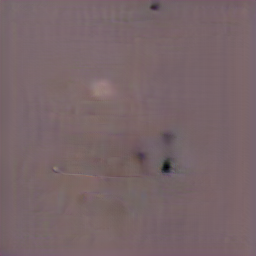

[tensor([0.0036], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.7521, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.0354, device='cuda:0', grad_fn=<DivBackward0>)]
updated mse weight: 1.2


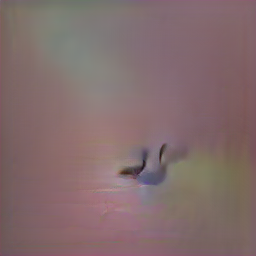

[tensor([0.0061], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.6666, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.1717, device='cuda:0', grad_fn=<DivBackward0>)]
updated mse weight: 0.8999999999999999


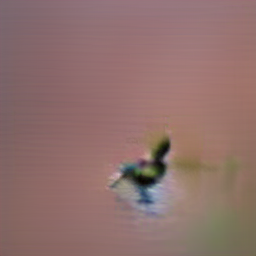

[tensor([0.0078], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.6451, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.1929, device='cuda:0', grad_fn=<DivBackward0>)]
updated mse weight: 0.5999999999999999


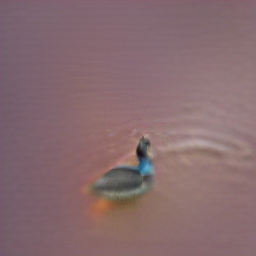

[tensor([0.0080], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.6106, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.1243, device='cuda:0', grad_fn=<DivBackward0>)]
updated mse weight: 0


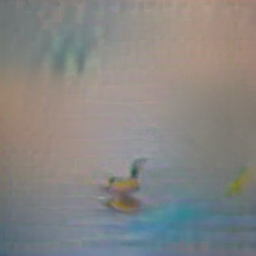

[tensor([0.0057], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.6653, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.1272, device='cuda:0', grad_fn=<DivBackward0>)]
updated mse weight: 0


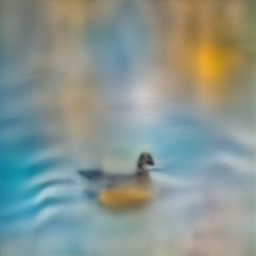

[tensor([0.0097], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.5724, device='cuda:0', grad_fn=<MulBackward0>), tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]


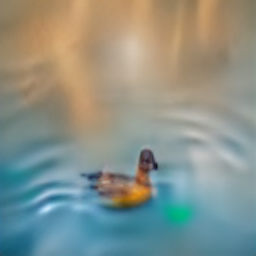

[tensor([0.0120], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.5604, device='cuda:0', grad_fn=<MulBackward0>), tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]


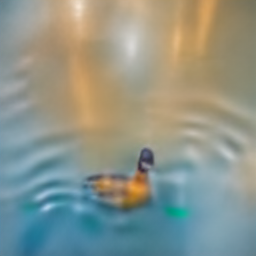

[tensor([0.0092], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.5620, device='cuda:0', grad_fn=<MulBackward0>), tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]


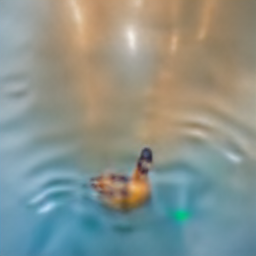

[tensor([0.0092], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.5502, device='cuda:0', grad_fn=<MulBackward0>), tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]


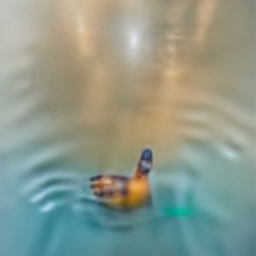

[tensor([0.0115], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.5543, device='cuda:0', grad_fn=<MulBackward0>), tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]


In [12]:
## 一个示例
args=Trainer_Args()
prompt='在水面上游泳的鸭子'
model_type='vqgan'
lang='cn'
epoch=200
test_config={
                'prompt':prompt,
                'model_type':model_type,
                'lang':lang,
                'epochs':epoch,
            }
set_args(model_type)
d=generate(**test_config)
clear_cuda_cache()

### Tips（CLIP guided VQVAE）
#### gradient初始化最平滑
#### 学习率过大会导致引入较大噪声，而且很难去掉
#### 正则项过大导致色调偏暗，0.5
#### 随机噪声有利于加快学习速度
#### 随机噪声过大导致图像噪声多，难消除

### maybe best config:
#### lr:0.1
#### noise_fac:0.2 or 0.1
#### mse_weight:1.5
#### init_noise:gradient

> ## 图像编辑
> ### 效果不佳

In [ ]:
from IPython import display
def visualise(source, masks):
    source=TF.to_tensor(source)
    colored_mask = [1., 0., 0.]
    colored_mask = torch.tensor(colored_mask)
    colored_mask = colored_mask.view((3,1)).expand((3, source.shape[1]))
    colored_mask = colored_mask.view((3, source.shape[1], 1)).expand(source.shape)
    print(source.shape)
    for img in masks:
        print(colored_mask.shape,img.shape)
        colored_mask = torch.cat([colored_mask, img[None]], dim=0)
        Image.alpha_composite(TF.to_pil_image(source).convert('RGBA'),\
            TF.to_pil_image(colored_mask).convert('RGBA')).save('tp_mask.png')
        display.display(display.Image('tp_mask.png'))

torch.Size([3, 358, 500])
torch.Size([3, 358, 500]) torch.Size([358, 500])


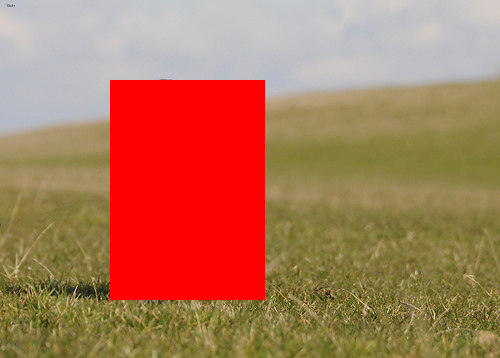

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [12]:
from PIL import Image
source = Image.open('/kaggle/input/dog-and-cat-detection/images/Cats_Test1001.png').convert('RGB')
box = 110,80,265,300
x1,y1,x2,y2=box
mask = torch.zeros([source.size[1], source.size[0]])
mask[y1:y2, x1:x2] = 1.
#mask=1-mask
masks= [mask]
new_p = TF.to_pil_image(masks[0])
new_p.save('mask.png')
visualise(source,masks)
mask

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
Loading vision model config from /opt/conda/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /opt/conda/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}
prompt: 一只狗在雪地上奔跑
lang: cn
model_type: vqgan
init_noise: None
time: 0


  0%|          | 0/200 [00:00<?, ?it/s]

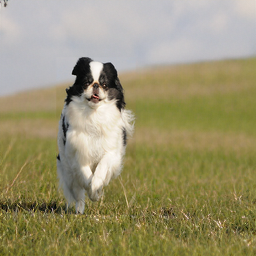

[tensor(0., device='cuda:0', grad_fn=<MulBackward0>), tensor([0.2259], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.6952, device='cuda:0', grad_fn=<MulBackward0>), tensor(0., device='cuda:0', grad_fn=<DivBackward0>)]


 10%|█         | 20/200 [00:11<01:47,  1.68it/s]

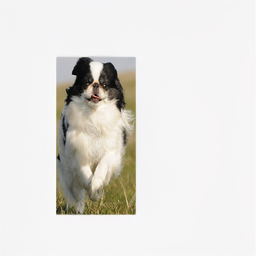

[tensor(0., device='cuda:0', grad_fn=<MulBackward0>), tensor([0.1418], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.7025, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.9602, device='cuda:0', grad_fn=<DivBackward0>)]


 12%|█▎        | 25/200 [00:14<01:44,  1.67it/s]

updated mse weight: 1.2


 20%|██        | 40/200 [00:23<01:35,  1.68it/s]

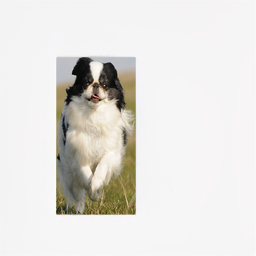

[tensor(0., device='cuda:0', grad_fn=<MulBackward0>), tensor([0.1418], device='cuda:0', grad_fn=<MulBackward0>), tensor(0.7069, device='cuda:0', grad_fn=<MulBackward0>), tensor(0.7684, device='cuda:0', grad_fn=<DivBackward0>)]


 24%|██▍       | 49/200 [00:29<01:30,  1.67it/s]


KeyboardInterrupt: 

In [60]:
%%time
prompt='一只狗在雪地上奔跑'
args.lr=0.05
args.mask_weight=0
args.mse_weight=1.5
args.mse_decay_rate=25
args.noise_fac=0
args.tv_loss_weight=50
args.use_augs=True
config={
    'prompt':prompt,
    #'init_noise':'gradient',
    'model_type':'vqgan',
    'epochs':200,
    'lang':'cn',
    'init_image':'/kaggle/input/dog-and-cat-detection/images/Cats_Test1001.png',
    'mask':True
}
d=generate(**config)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


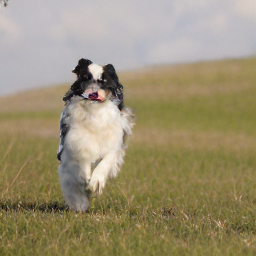

In [55]:
model=load_model()
z=d['z']
out=decode(model,z)
imshow(out)

In [57]:
args.mask.sum()

tensor(12484.2129, device='cuda:0')